How to Organize the Single Notebook (project_final.ipynb)
Each major section should have a large Markdown heading (#) followed by code cells.


Section Title (Markdown)	What goes inside
 1. Introduction	Problem statement, project goals
 2. Imports & Setup	All import statements and helper functions
 3. Data Exploration (EDA)	Load CSVs, check missing files, plot distributions
 4. Data Preparation	Train/Val/Test split, normalization, dataset class
 5. Model Building	Define baseline CNN model (later extend if needed)
 6. Training Loop	Training code, save best model
 7. Evaluation	Confusion matrix, classification report, plots
 8. Error Analysis	Misclassified samples, Grad-CAM (optional)
 9. Final Judgement	Pick best model, justify choice
 10. Independent Evaluation	Compare your results with literature
 11. Conclusion	Wrap up and future directions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

#torch
import torch
from torch import nn

#torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold

import random
from PIL import Image
from pathlib import Path

### Data Exploration

In [4]:
base_dir = os.getcwd()
image_dir = os.path.join(base_dir,'data','images')
labels_main_dir = os.path.join(base_dir,"data","labels_main.csv")

In [25]:
labels_main = pd.read_csv(labels_main_dir)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [6]:
labels_main['imagePath'] = labels_main['ImageName'].apply(lambda x: os.path.join(image_dir,x))
labels_main['imageExists'] = labels_main['imagePath'].apply(lambda x: os.path.exists(x))
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath,imageExists
0,22405,1,22405.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
1,22406,1,22406.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
2,22407,1,22407.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
3,22408,1,22408.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
4,22409,1,22409.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True


In [7]:
print(labels_main.imageExists.value_counts())

imageExists
True    9896
Name: count, dtype: int64


In [12]:
print(f"Unique values in 'cellTypeName' :{labels_main.cellTypeName.unique()}")
print(f"Unique values in 'cellType' \t:{labels_main.cellType.unique()}")
print(f"Unique values in 'isCancerous \t:{labels_main.isCancerous.unique()}")

Unique values in 'cellTypeName' :['fibroblast' 'inflammatory' 'others' 'epithelial']
Unique values in 'cellType' 	:[0 1 3 2]
Unique values in 'isCancerous 	:[0 1]


In [14]:
print(f"No of patients :{labels_main.patientID.nunique()}")

No of patients :60


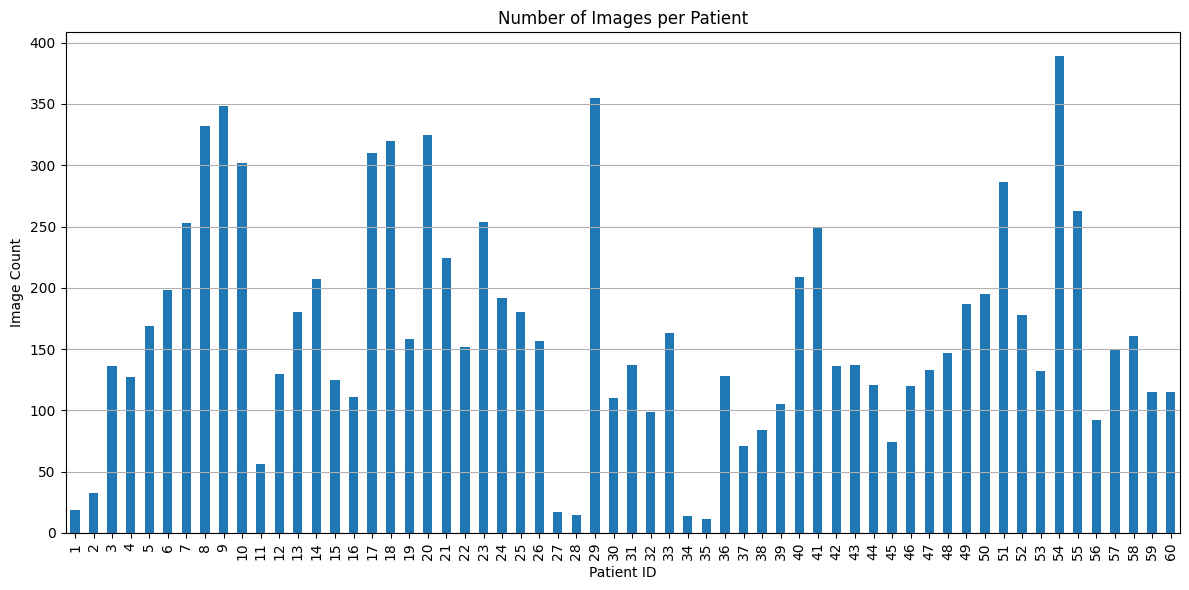

In [30]:
patient_image_counts = pd.DataFrame(labels_main.patientID.value_counts().sort_index())

patient_image_counts.plot(kind='bar', legend=False, figsize=(12, 6))
plt.title('Number of Images per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Image Count')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [39]:
print(labels_main[['cellTypeName', 'cellType']].drop_duplicates().sort_values(by='cellType'))

     cellTypeName  cellType
0      fibroblast         0
11   inflammatory         1
449    epithelial         2
17         others         3


   cellTypeName  Raw_count  Raw_proportion
0    epithelial       4079            41.2
1  inflammatory       2543            25.7
2    fibroblast       1888            19.1
3        others       1386            14.0


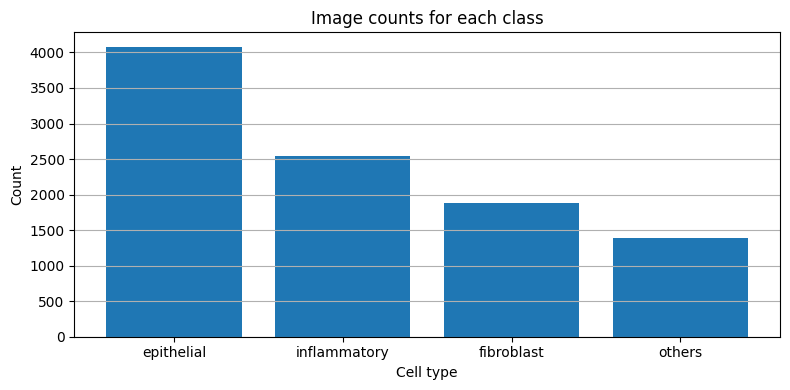

In [50]:
cellType_counts = labels_main['cellTypeName'].value_counts().reset_index()
cellType_counts.columns = ['cellTypeName', 'Raw_count']
cellType_counts['Raw_proportion'] = round((cellType_counts['Raw_count'] / cellType_counts['Raw_count'].sum()) * 100, 1)

print(cellType_counts)

plt.figure(figsize=[8,4])
plt.bar(cellType_counts['cellTypeName'],cellType_counts['Raw_count'])
plt.title('Image counts for each class')
plt.xlabel('Cell type')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In [21]:
patient_cellType = labels_main.groupby(['patientID', 'cellTypeName']).size().unstack(fill_value=0)
patient_cellType.head()

cellTypeName,epithelial,fibroblast,inflammatory,others
patientID,,,,
1,0,11,6,2
2,0,8,18,7
3,0,53,73,10
4,0,39,81,7
5,35,25,103,6


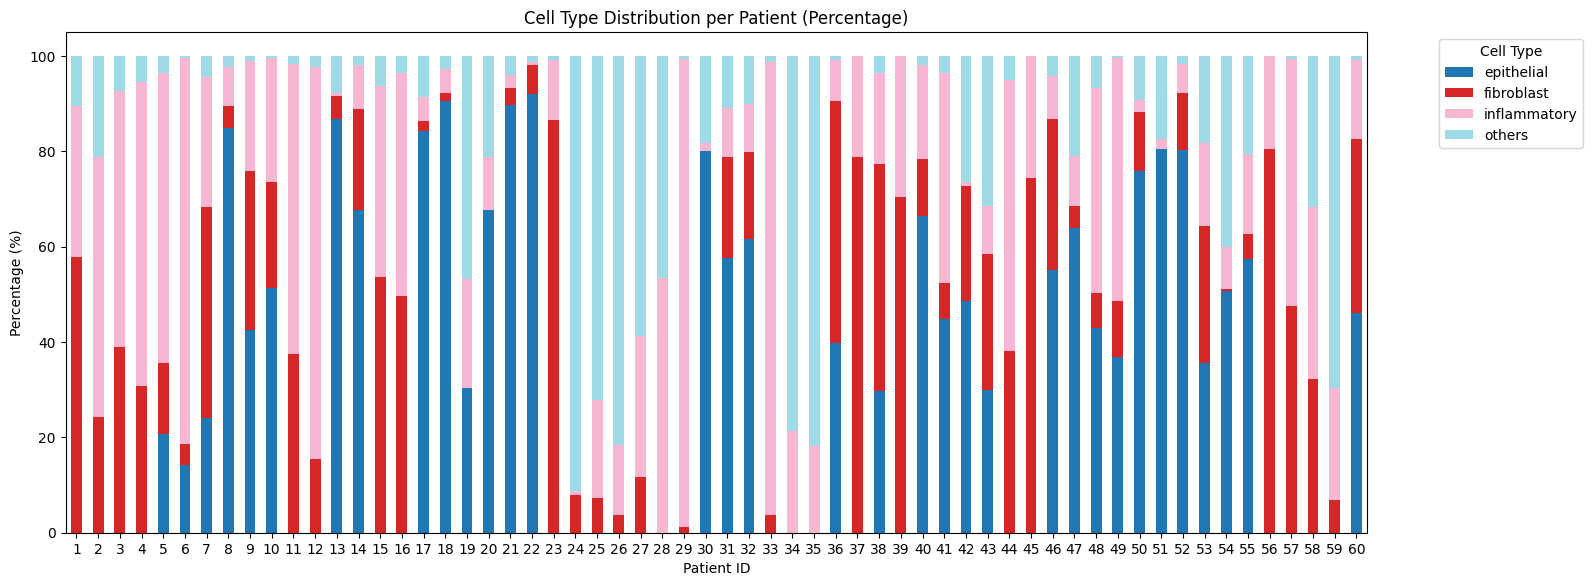

In [60]:
cell_percentages = patient_cellType.div(patient_cellType.sum(axis=1), axis=0) * 100

# Sort by patient ID for consistent plotting
cell_percentages = cell_percentages.sort_index()

# Plot
cell_percentages.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    colormap='tab20'
)

plt.ylabel("Percentage (%)")
plt.xlabel("Patient ID")
plt.title("Cell Type Distribution per Patient (Percentage)")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [34]:
y = labels_main["cellType"]      
groups = labels_main["patientID"]      

# first split for test data
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=24)  

train_val_idx, test_idx = next(sgkf.split(labels_main, y, groups))               # take the first fold as test
df_train_val = labels_main.iloc[train_val_idx].reset_index(drop=True)
df_test      = labels_main.iloc[test_idx]     .reset_index(drop=True)

# second split for val data
y_tv      = df_train_val["cellType"]
groups_tv = df_train_val["patientID"]

sgkf_val = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=24)   # 1/4 ≈ 25 % of train_val ⇒ 20 % overall
train_idx, val_idx = next(sgkf_val.split(df_train_val, y_tv, groups_tv))

df_train = df_train_val.iloc[train_idx].reset_index(drop=True)
df_val   = df_train_val.iloc[val_idx].reset_index(drop=True)

In [35]:
# ▶ 3. Sanity checks ────────────────────────────────────────────────────────
def show_split_stats(name, dframe):
    print(f"{name:5}  patients={dframe['patientID'].nunique():3}  samples={len(dframe):5}")
    print(dframe["cellTypeName"].value_counts(normalize=True).mul(100).round(1), "\n")

for split_name, split_df in [("TRAIN", df_train), ("VAL", df_val), ("TEST", df_test)]:
    show_split_stats(split_name, split_df)

TRAIN  patients= 33  samples= 5772
cellTypeName
epithelial      36.1
inflammatory    29.1
fibroblast      20.1
others          14.7
Name: proportion, dtype: float64 

VAL    patients= 13  samples= 1927
cellTypeName
epithelial      54.7
inflammatory    21.7
fibroblast      12.7
others          10.9
Name: proportion, dtype: float64 

TEST   patients= 14  samples= 2197
cellTypeName
epithelial      42.8
fibroblast      22.1
inflammatory    20.3
others          14.8
Name: proportion, dtype: float64 



In [51]:
train_percentages = df_train['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
train_percentages.columns=['cellTypeName','Train_proportion']
cellType_counts = cellType_counts.merge(train_percentages,left_on='cellTypeName',right_on='cellTypeName')

val_percentages = df_val['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
val_percentages.columns=['cellTypeName','Val_proportion']
cellType_counts = cellType_counts.merge(val_percentages,left_on='cellTypeName',right_on='cellTypeName')

test_percentages = df_test['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
test_percentages.columns=['cellTypeName','Test_proportion']
cellType_counts =  cellType_counts.merge(test_percentages,left_on='cellTypeName',right_on='cellTypeName')

cellType_counts
                                    

,cellTypeName,Raw_count,Raw_proportion,Train_proportion,Val_proportion,Test_proportion
0,epithelial,4079,41.2,36.1,54.7,42.8
1,inflammatory,2543,25.7,29.1,21.7,20.3
2,fibroblast,1888,19.1,20.1,12.7,22.1
3,others,1386,14.0,14.7,10.9,14.8


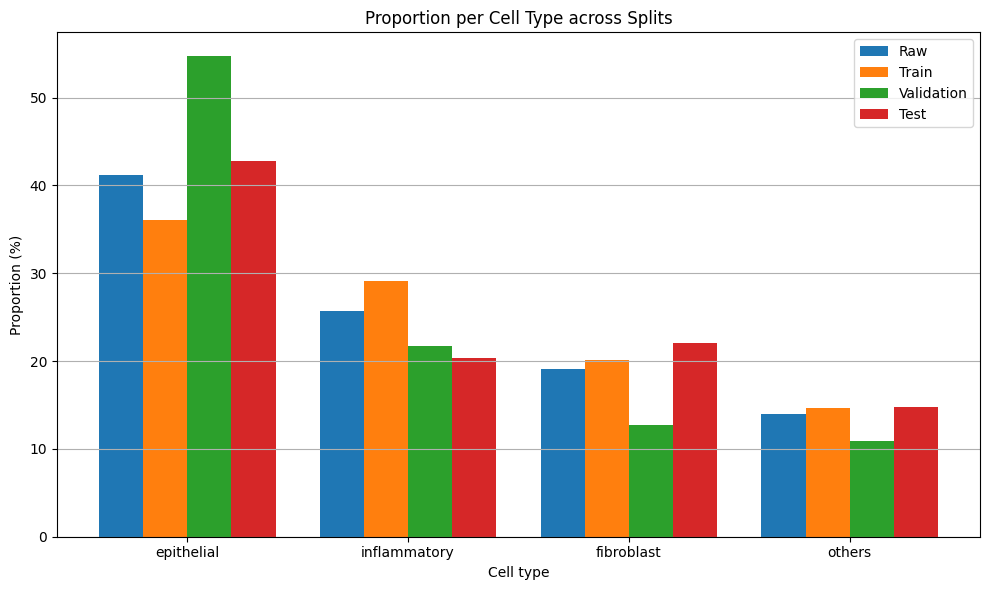

In [53]:
# Assume your dataframe is called df
categories = cellType_counts['cellTypeName']
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group
ax.bar(x - width*1.5, cellType_counts['Raw_proportion'], width, label='Raw')
ax.bar(x - width/2, cellType_counts['Train_proportion'], width, label='Train')
ax.bar(x + width/2, cellType_counts['Val_proportion'], width, label='Validation')
ax.bar(x + width*1.5, cellType_counts['Test_proportion'], width, label='Test')

# Labels and title
ax.set_xlabel('Cell type')
ax.set_ylabel('Proportion (%)')
ax.set_title('Proportion per Cell Type across Splits')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

In [82]:
class ColonCellDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['imagePath']).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = row['cellType']
        return image, label


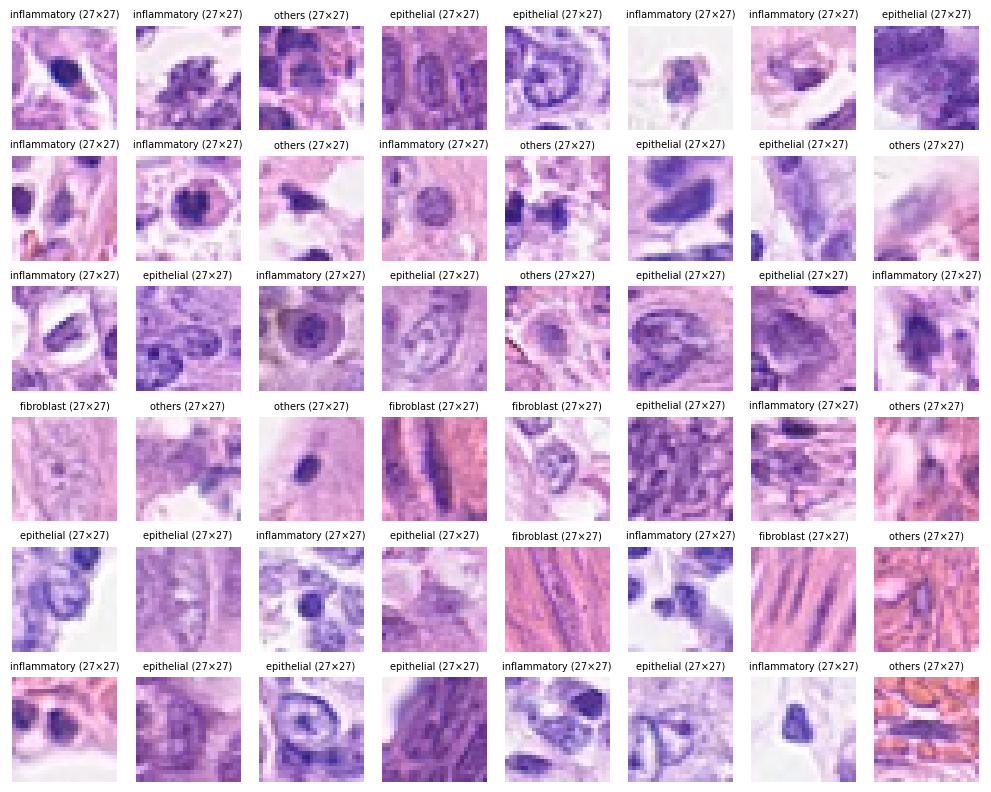

In [ ]:
# visualize random set of images with cell type label and image sizes

# randomly select 54 images
sampled_df = labels_main.sample(n=54, random_state=42).reset_index(drop=True)

image_dir = Path('data/images')

# plot
rows = 6
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(10, 8)) 
for ax, (_, row) in zip(axes.flatten(), sampled_df.iterrows()):
    img_path = image_dir / row['ImageName']
    
    img = Image.open(img_path)
    width, height = img.size
    ax.imshow(img)
    ax.set_title(f"{row['cellTypeName']} ({width}×{height})", fontsize=7)
    
    ax.axis('off')

plt.tight_layout()
plt.show()